<h1>Emotion Sentiment Analysis</h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
base = 'drive/My Drive/Colab Notebooks/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv(base + "master.csv", encoding='utf-8')
df = df.reindex(np.random.permutation(df.index))
df['content'] = df['content'].astype(str)

In [6]:
vocabulary_size = 200000
tokenizer = Tokenizer(num_words= 1000)
tokenizer.fit_on_texts(df['content'])

In [7]:
word2index = tokenizer.word_index
index2word = {i:j for i, j in enumerate(word2index)}

In [8]:
df.head()

,emotion,content
161441,fear,i jump or screech or otherwise make a total fo...
17064,sad,i've been feeling a little melancholy this las...
301632,love,i feel like some of you have pains and you can...
75363,anger,i'm feeling dissatisfied aside from my satisfa...
236503,fear,i walked out of the store feeling unsure of wh...


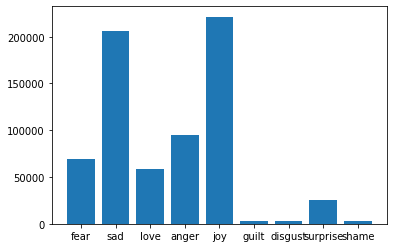

In [9]:
emotions = df.emotion.unique()
sum_categorical_emotions = [df[df.emotion == i].size for i in emotions]
plt.bar(emotions, sum_categorical_emotions)
plt.show()

<h4>The basic human emotion classes can be as follows</h4>
<ul>
<li>Happiness
<li>Sadness
<li>Fear
<li>Disgust
<li>Anger
<li>love
<li>Surprise
<li>disgust
<li>guilt
</ul>

In [10]:
df.loc[df.emotion == 'guilt', 'emotion'] = 'disgust'
df.loc[df.emotion == 'disgust', 'emotion'] = 'disgust'
df.loc[df.emotion == 'shame', 'emotion'] = 'disgust'
df.loc[df.emotion == 'joy', 'emotion'] = 'happiness'
df.loc[df.emotion == 'love', 'emotion'] = 'happiness'
df.emotion.unique()

array(['fear', 'sad', 'happiness', 'anger', 'disgust', 'surprise'],
      dtype=object)

[69616, 206492, 279482, 94636, 8714, 25300]


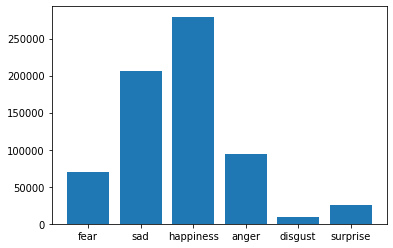

In [17]:
emotions = df.emotion.unique()
sum_categorical_emotions = [df[df.emotion == i].size for i in emotions]
print(sum_categorical_emotions)
plt.bar(emotions, sum_categorical_emotions)
plt.show()

<h1>Using word embeddings to create a LSTM classification model</h1>

In [18]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

In [19]:
sequences = tokenizer.texts_to_sequences(df['content'])
data = pad_sequences(sequences, maxlen=50)
X = data.reshape(len(data), 50)
X[100]

array([  0,   0,   0,   0,   0,   0,   0,   0,  30,   1,  15, 219, 290,
         1,  15,  46,   6,  30,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2, 174,   7], dtype=int32)

In [20]:
flag = pd.Series(list(df['emotion']))
Y = pd.get_dummies(flag)
Y = np.array(Y)
Y[100]

array([0, 1, 0, 0, 0, 0], dtype=uint8)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [23]:
inputs = Input(shape=[50])
layer = Embedding(100000, 500, input_length=50)(inputs)
layer = LSTM(512)(layer)
layer = Dense(256)(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(6)(layer)
layer = Activation('softmax')(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 500)           50000000  
                                                                 
 lstm_2 (LSTM)               (None, 512)               2074624   
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542

In [24]:
model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
896/896 [==============================] - 192s 208ms/step - loss: 0.3805 - accuracy: 0.8619 - val_loss: 0.2253 - val_accuracy: 0.9166
Epoch 2/10
896/896 [==============================] - 185s 207ms/step - loss: 0.2210 - accuracy: 0.9187 - val_loss: 0.2163 - val_accuracy: 0.9198
Epoch 3/10
896/896 [==============================] - 185s 207ms/step - loss: 0.2103 - accuracy: 0.9221 - val_loss: 0.2097 - val_accuracy: 0.9212
Epoch 4/10
896/896 [==============================] - 185s 206ms/step - loss: 0.2028 - accuracy: 0.9236 - val_loss: 0.2061 - val_accuracy: 0.9234
Epoch 5/10
896/896 [==============================] - 185s 207ms/step - loss: 0.1959 - accuracy: 0.9255 - val_loss: 0.2077 - val_accuracy: 0.9238
Epoch 6/10
896/896 [==============================] - 184s 206ms/step - loss: 0.1881 - accuracy: 0.9279 - val_loss: 0.2019 - val_accuracy: 0.9253
Epoch 7/10
896/896 [==============================] - 186s 208ms/step - loss: 0.1776 - accuracy: 0.9312 - val_loss: 0.1994 -

In [25]:
model.save('master_model.h5')

<h1>Prediction and Evaluation</h1>

In [26]:
from keras.models import load_model
model = load_model('master_model.h5')

In [27]:
y_predict = model.predict(X_test)

In [28]:
from sklearn.metrics import confusion_matrix
predict = np.argmax(y_predict, axis = 1)
y_test_class = np.argmax(y_test, axis = 1)
cm = confusion_matrix(predict, y_test_class)

Text(0.5, 1.0, 'Confusion Matrix')

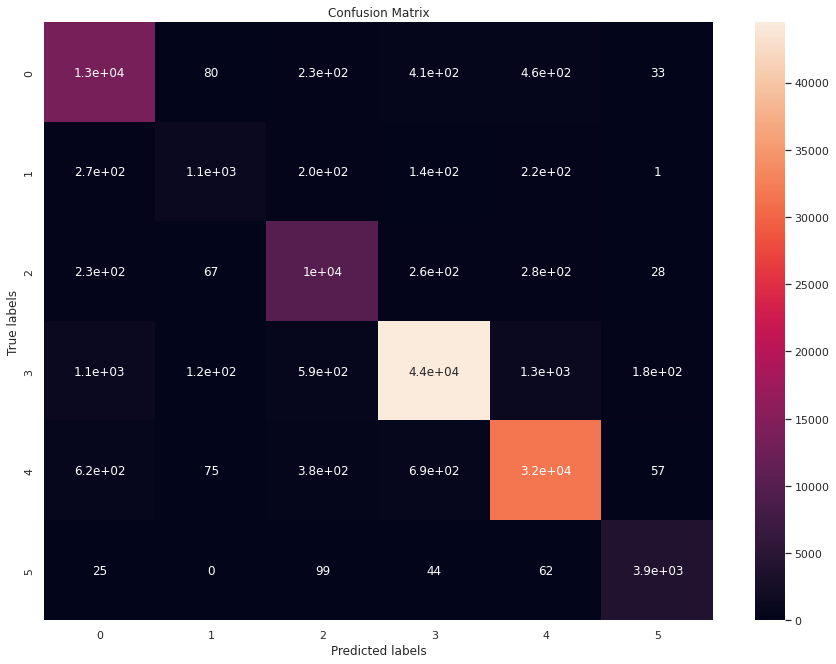

In [30]:
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
sns.set(rc={'figure.figsize':(15, 11)})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [31]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test_class, predict)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('emotion: {}'.format(emotions))

precision: [0.91720746 0.57047668 0.9201727  0.93075668 0.94572256 0.94421538]
recall: [0.85593166 0.76758621 0.8690786  0.9666826  0.9311905  0.92933874]
fscore: [0.88551078 0.65451338 0.89389613 0.94837953 0.93840027 0.936718  ]
support: [15687  1450 11526 46012 34036  4189]
emotion: ['fear' 'sad' 'happiness' 'anger' 'disgust' 'surprise']


In [33]:
score_table = PrettyTable(['Emotion', 'Precision', 'Recall', 'F-score', 'Support'])
for i in range(0, len(emotions)):
    score_table.add_row([emotions[i], precision[i], recall[i], fscore[i], support[i]])
print(score_table)

+-----------+--------------------+--------------------+--------------------+---------+
|  Emotion  |     Precision      |       Recall       |      F-score       | Support |
+-----------+--------------------+--------------------+--------------------+---------+
|    fear   | 0.9172074595259239 | 0.8559316631605788 | 0.8855107828266173 |  15687  |
|    sad    | 0.5704766786263454 | 0.7675862068965518 | 0.6545133784181124 |   1450  |
| happiness | 0.9201726988792945 | 0.8690786048932847 | 0.8938961270747813 |  11526  |
|   anger   | 0.9307566753159789 | 0.9666826045379466 | 0.9483795309168443 |  46012  |
|  disgust  | 0.9457225554262525 | 0.9311905041720531 | 0.9384002723948541 |  34036  |
|  surprise | 0.9442153771525588 | 0.9293387443303891 | 0.9367179980750722 |   4189  |
+-----------+--------------------+--------------------+--------------------+---------+


In [34]:
statement = "It was very dark outside."
sequences = tokenizer.texts_to_sequences([statement])
data = pad_sequences(sequences, maxlen=50)
emotion = df.emotion.unique()
y = model.predict(data)
y = np.argmax(y)
print(emotion[y])

fear
